<a href="https://colab.research.google.com/github/Jectrianama/GCCE_TEST/blob/main/Majority_Voting1/mv_skin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
#!pip install tensorflow==2.7.0
#!pip install scikeras

# Subclassing for MV

In [39]:
import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, roc_auc_score, mutual_info_score, normalized_mutual_info_score, adjusted_mutual_info_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import mode 
import numpy as np

def ook(t):
  lb = LabelBinarizer()
  y_ook = lb.fit_transform(t)  

  if len(np.unique(t))==2:
    y_ook = np.concatenate((1-y_ook.astype(bool), y_ook), axis = 1) 

  return y_ook


def onehot_encode(df, columns):
    df = df.copy()
    for column in columns:
        dummies = pd.get_dummies(df[column], prefix=column)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

def preprocess_inputs(df):
    df = df.copy()
    
    # Encode label values as numbers
    df['V10'] = df['V10'].replace({'negative': 0, 'positive': 1})
    
    # One-hot encode board space columns
    df = onehot_encode(
        df,
        columns=['V' + str(i) for i in range(1, 10)]
    )
    
    # Split df into X and y
    y = df['V10'].copy()
    X = df.drop('V10', axis=1).copy()
    
    # Train-test split
   # X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    
    return X, y



def evaluation_metrics(y_true, y_pred, print_result=True):
    acc = 0
    auc = 0
    auc_sk = 0
    #mi = 0
    nmi = 0
    #ami = 0
    bacc = 0
    
    # Accuracy
    #report = classification_report(y_pred.argmax(axis=1), y_true.ravel(), output_dict=True)
    acc = accuracy_score( y_true.ravel(), y_pred.argmax(axis=1))  #report['accuracy']
    
    # Balanced accuracy
    bacc = balanced_accuracy_score(y_true.squeeze(), y_pred.argmax(axis=1).squeeze(), adjusted=True)
    
   # # Mutual Information
   # mi = mutual_info_score(y_true.squeeze(), y_pred.argmax(axis=1).squeeze())
    
    # Normalized Mutual Information
    nmi = normalized_mutual_info_score(y_true.squeeze(), y_pred.argmax(axis=1).squeeze())
    
    # Adjusted Mutual Information
    #ami = adjusted_mutual_info_score(y_true.squeeze(), y_pred.argmax(axis=1).squeeze())
    
    # AUC (Tensorflow)
    auc_metric = tf.keras.metrics.AUC(from_logits=True)
    auc_metric.update_state(y_true, y_pred.argmax(axis=1).astype('float'))
    auc = auc_metric.result().numpy()
    auc_metric.reset_states()
    
    # AUC (scikit-learn)
    auc_sk = roc_auc_score(ook(y_true), y_pred)
    
    if print_result:
        print("Accuracy: {:.4f}".format(acc))
        print("Balanced Accuracy: {:.4f}".format(bacc))
       # print("Mutual Information: {:.4f}".format(mi))
        print("Normalized Mutual Information: {:.4f}".format(nmi))
        #print("Adjusted Mutual Information: {:.4f}".format(ami))
        print("AUC (Tensorflow): {:.4f}".format(auc))
        print("AUC (scikit-learn): {:.4f}".format(auc_sk))
    
    return acc, auc, auc_sk, nmi, bacc   # mi, , ami




In [40]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import matplotlib.pyplot as plt
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow_probability as tfp
from tensorflow.keras import regularizers
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import train_test_split
tf.keras.backend.clear_session()
#tf.random.set_seed(42)
import types
import tempfile
class Keras_MA_GCCE():  
 #Constructor __init__. Special method: identified by a double underscore at either side of their name
 #work in the background
 # initialize data members to the object. lets the class initialize the object’s attributes and serves no other purpose.
    def __init__(self,epochs=100,batch_size=30,R=5, K=2, dropout=0.5, learning_rate=1e-3,optimizer='Adam', 
                  l1_param=0, validation_split=0.3, verbose=1, q = 0.1, neurons=1.5, loss = "GCE" ):
        self.epochs=epochs
        self.dropout=dropout
        self.batch_size = batch_size
        self.learning_rate=learning_rate 
        self.l1_param=l1_param 
        self.l2_param=l1_param
        self.validation_split = validation_split
        self.verbose = verbose
        self.optimizer = optimizer
        self.R=R
        self.K=K
        self.q = q
        self.neurons = neurons
        self.loss = loss
    

    
 
    def GCE_MA_loss(self, y_true, y_pred):
        # print(y_true,y_pred)
       # q = 0.1
        pred = y_pred[:, self.R:]
        pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1)
        ann_ = y_pred[:, :self.R]
        # ann_ = tf.clip_by_value(ann_, clip_value_min=1e-9, clip_value_max=1-1e-9)
        Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1)
        #tf.print(tf.reduce_sum(Y_true[1,:,0]))
        #tf.print(y_true[1,0])
        Y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis = -1)

        p_gcce = Y_true*(1 - Y_hat**self.q)/self.q
        temp1 = ann_*tf.math.reduce_sum(p_gcce, axis=1)
        temp2 = (1 - ann_)*(1-(1/self.K)**self.q)/self.q*tf.reduce_sum(Y_true,axis=1)
        return tf.math.reduce_sum((temp1 + temp2))
    
    
    def custom_RCDNN_loss(self, y_true, y_pred):  #ytrue \in N x R,  ypred \in N x (R+K) -> PRI->JULI
    
        #Input ytrue: samples (N) x  annotators (R) 
        #Input ypred: samples (N) x  annotators+classes (R+K) 

        #Ground truth estimation samples (N) x  Classes(K)
        pred = y_pred[:,self.R:]
        pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1-1e-9) #estabilidad numerica de la funcion de costo
        # Annotators reliability prediction: samples (N) x  annotators (R)
        ann_ = y_pred[:,:self.R]
        #Y_true 1-K: samples (N) x  Classes(1-K), annotators (R)
        Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1)
        #Y_pred 1 - K: samples (N) x  Classes(1-K), annotators (R)
        Y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis = -1)
        #loss computation
        p_logreg = tf.math.reduce_prod(tf.math.pow(Y_hat, Y_true), axis=1)
        temp1 = ann_*tf.math.log(p_logreg)  
        temp2 = (1 - ann_)*tf.math.log(1/self.K)*tf.reduce_sum(Y_true,axis=1)
        # temp2 = (tf.ones(tf.shape(ann_)) - ann_)*tf.math.log(1/K)
        # print(tf.reduce_mean(Y_true,axis=1).numpy())
        return -tf.math.reduce_sum((temp1 + temp2))

 
    def PRI_MA_loss(self, y_true, y_pred): #,  -> PRI
        #Input ytrue: samples (N) x  annotators (R) 
        #Input ypred: samples (N) x  annotators+classes (R+K) 
        #PRI MA
        cce_M = tf.keras.losses.CategoricalCrossentropy(reduction='none',axis=-1)
        cce_C = tf.keras.losses.CategoricalCrossentropy(reduction='none',axis=1)

      

        #N = tf.cast(y_true.shape[0],dtype=tf.int32)
        N = tf.shape(y_true)[0]
        #Ground truth estimation samples (N) x  Classes(K)
        y_pred_tf = y_pred[:,self.R:] 
        # Annotators reliability prediction: samples (N) x  annotators (R)
        lambda_R_tf = y_pred[:,:self.R] #tf.ones(shape=(N,R)) 
        #Y_true 1 K: samples (N) x  Classes(1-K), annotators (R)
        Y_true_1K = tf.one_hot(tf.cast(y_true,dtype=tf.int32),depth=self.K,axis=1)  
        #Y_pred 1 - K: samples (N) x  Classes(1-K), annotators (R)
        Y_hat = tf.repeat(tf.expand_dims(y_pred_tf,-1), self.R, axis = -1) 
        #marginal entropy
        #cce along the K classes -> ypred_tf
        Hm_ = cce_M(y_pred_tf,y_pred_tf)
        #cross entropy
        #cce along the K classes -> Y_hat
        Hc_ = cce_C(Y_true_1K,Y_hat)
        #PRI MA computation
        LH = tf.linalg.matmul(lambda_R_tf,Hc_,transpose_a=True) # \Lambda^\top H_c
        temp1 = tf.linalg.trace(LH) #trace(LH)
        Hm1L = tf.linalg.matmul(tf.ones(shape=(N,self.R))-lambda_R_tf,tf.ones(shape=(self.R,1)))# 1_N 1_R^\top - Lambda
        Hm_t = tf.reshape(Hm_,shape=(N,1))
        temp2 = tf.squeeze(tf.linalg.matmul(Hm_t,Hm1L,transpose_a=True)) # Hm^\top Hm1L
        loss_c = temp1+ temp2 #return loss

        return loss_c

    def fit(self, X, Y):
        initializer = tf.keras.initializers.GlorotNormal(seed=100)
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)

        def scheduler1(step = 10, ratio = 1.2):
          def scheduler(epoch, lr):
            if epoch % step == 0 and epoch>1:
              return lr/ratio
            else:
              return lr
          return scheduler
        P = X.shape[1]
        
        if self.optimizer == "Adam":
            opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        elif self.optimizer == "SGD":
            opt = tf.keras.optimizers.SGD(learning_rate=self.learning_rate)
        elif self.optimizer == "RMSprop":
            opt = tf.keras.optimizers.RMSprop(learning_rate=self.learning_rate)
        elif self.optimizer == "Adagrad":
            opt = tf.keras.optimizers.Adagrad(learning_rate=self.learning_rate)
        else:
            opt=self.optimizer


        if self.loss == "RCDNN":
          sel_loss = self.custom_RCDNN_loss
        elif  self.loss == "GCE":
          sel_loss = self.GCE_MA_loss
        
        #capa de entrada
        input_l = tf.keras.layers.Input(shape=(X_train.shape[1]), name='entrada')
        input_l_b = tf.keras.layers.BatchNormalization()(input_l)        
        input_l_do = tf.keras.layers.Dropout(rate=self.dropout)(input_l_b)    
        #capas densas
        h1 = tf.keras.layers.Dense(int(P*self.neurons*(self.K+self.R)),activation='selu',name='h1', bias_initializer='zeros', kernel_initializer=initializer,
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(input_l_do)#argumento de entrada
       # h1 = tf.keras.layers.BatchNormalization()(h1)        
        h1 = tf.keras.layers.AlphaDropout(rate=self.dropout)(h1)      
        h2 = tf.keras.layers.Dense(int(P*(self.K+self.R)),activation='selu',name='h2', bias_initializer='zeros', kernel_initializer=initializer,
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(h1)
        #h2 = tf.keras.layers.BatchNormalization()(h2)     
        dout = tf.keras.layers.AlphaDropout(rate=self.dropout)(h2)
        #capa de salida
        output = tf.keras.layers.Dense(self.K,activation="softmax",name='output',
                                   kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(dout)
        self.model = tf.keras.Model(inputs= input_l,outputs=output)
        self.model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=opt,metrics=["accuracy"])
         
        
 

        callback1 = tf.keras.callbacks.TerminateOnNaN()
        callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler1(ratio = 1))
        #callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler2)
        callback3 = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=1e-2,
                                                 patience=15, verbose=0, mode="auto",
                                                 baseline=None, restore_best_weights=True)
            
 
        self.history = self.model.fit(X, Y, epochs=self.epochs, validation_split=self.validation_split, callbacks = [callback1, callback2],   #
                                      batch_size=self.batch_size,verbose=self.verbose)
 
        return self
 
  
  
    
    def predict(self, X, *_):
       #input X numpy array first dimension samples (N)x features (P)
      return  self.model.predict(X) 
 
 

    def fit_predict(self,X,y):
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)

        self.fit(X,y)
        return self.predict(X)
    
    def model_MC(self, X, *_):
       #input X numpy array first dimension samples (N)x features (P)
        return  self.model(X, training=True) 
 
  
     #graphics
    def plot_history(self):
        pd.DataFrame(self.history.history).plot(figsize=(8, 5))
        plt.grid(True)
        #plt.gca().set_ylim(0, 1)
        #save_fig("keras_learning_curves_plot")
        plt.show()
        return
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)

        return self
    
    
    
    def get_params(self, deep=True):
        return { 'l1_param':self.l1_param, 'dropout':self.dropout, 'optimizer':self.optimizer,
                'learning_rate':self.learning_rate, 'batch_size':self.batch_size,
                'epochs':self.epochs, 'verbose':self.verbose, 'validation_split':self.validation_split,
                'R':self.R, 'K':self.K, 'q':self.q
                }

  
        return self


# Load Data

In [41]:
#load data
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf #importar tensorflow
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
database = 'Ocupancy' #['bupa1', 'breast-cancer-wisconsin1','pima-indians-diabetes1', 'ionosphere1', 'tic-tac-toe1', 'iris1', 'wine1', 'segmentation1']

 

In [42]:
#cargar datos desde drive acceso libre
FILEID = "1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW"
#https://drive.google.com/file/d/1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW/view?usp=sharing
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O MADatasets.zip && rm -rf /tmp/cookies.txt
!unzip -o MADatasets.zip
!dir

--2023-02-14 02:35:22--  https://docs.google.com/uc?export=download&confirm=t&id=1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW
Resolving docs.google.com (docs.google.com)... 74.125.24.101, 74.125.24.139, 74.125.24.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.24.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6k8r3324mi189d7pjfe79ops5iires81/1676342100000/07591141114418430227/*/1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW?e=download&uuid=bcf70a10-ffc0-4b49-a591-298cb38e097d [following]
--2023-02-14 02:35:24--  https://doc-00-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6k8r3324mi189d7pjfe79ops5iires81/1676342100000/07591141114418430227/*/1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW?e=download&uuid=bcf70a10-ffc0-4b49-a591-298cb38e097d
Resolving doc-00-90-docs.googleusercontent.com (doc-00-90-docs.googleusercontent.com)... 74.125.24.132, 2404:

In [43]:
#load data
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf #importar tensorflow
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
database = 'Skin_NonSkin' #['bupa1', 'breast-cancer-wisconsin1','pima-indians-diabetes1', 'ionosphere1', 'tic-tac-toe1', 'iris1', 'wine1', 'segmentation1']


path_ = 'MADatasets/'+ database+ '.mat' 
Xdata = sio.loadmat(path_)
Xdata.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Y', 'iAnn', 'Exp', 'idxtr', 'idxte'])

In [44]:


X = Xdata['X']
# Xte = Xdata['Xte']
Y = Xdata['Y']
t = Xdata['y'].reshape(-1)
print('X',X.shape,'t',t.shape,'Y',Y.shape)
 

X (245057, 3) t (245057,) Y (245057, 5)


In [45]:
t

array([1, 1, 1, ..., 2, 2, 2])

# Labels Generation

In [46]:
import random
import warnings
import numpy as np
#import climin
from functools import partial
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

#Defining the Sigmoid function and Softmax function
def Sigmoid(f_r):
    lam_r = 1/(1 + np.exp(-f_r))
    return lam_r

def MAjVot(Y, K):
    N,R = Y.shape
    Yhat = np.zeros((N,1))
    for n in range(N):
        votes = np.zeros((K,1))
        for r in range(R):
            for k in range(K):
                if Y[n,r] == k+1:
                    votes[k] = votes[k]+1
        Yhat[n] = np.argmax(votes) + 1
    return Yhat


def  MA_Clas_Gen(Xtrain,ytrain,R,NrP):

    N = len(ytrain)
    K = len(np.unique(ytrain))
    Kn = np.unique(ytrain)
    aux = 0
    A = np.zeros((K,1))
    for k in Kn:
        A[aux] = (ytrain == k).sum()
        aux = aux + 1
    per = np.min(A)
    if N < 25000:
        Xtrain = TSNE(n_components=1,perplexity=per/2).fit_transform(Xtrain)
    else:
        Xtrain = np.sum(Xtrain,1)
    # Xtrain = Xtrain-Xtrain.min()
    # Xtrain = Xtrain/Xtrain.max()
    #ytrain = y
    # scaler = StandardScaler()
    # scalerY = scaler.fit(y)
    # ytrain = scaler.fit_transform(y)

    
    #miny = y.min()
    #ytrain = y-miny
    #maxy = ytrain.max()
    #ytrain = ytrain/maxy
  
    # Xtrain = np.sum(Xtrain, axis=1)
    Xtrain = Xtrain - Xtrain.min()
    #print(Xtrain.min(), Xtrain.max())
    Xtrain = Xtrain/Xtrain.max()
    Xtrain = Xtrain.reshape((N,1))
    yprueba = np.ones((N,1))
    
    
    u_q = np.empty((Xtrain.shape[0],3))
    u_q[:,0,None] = 4.5*np.cos(2*np.pi*Xtrain + 1.5*np.pi) - \
                               3*np.sin(4.3*np.pi*Xtrain + 0.3*np.pi)
                    
    u_q[:,1,None] = 4.5*np.cos(1.5*np.pi*Xtrain + 0.5*np.pi) + \
                       5*np.sin(3*np.pi*Xtrain + 1.5*np.pi)
    
    u_q[:,2,None] = 1
    
    W = []
    # q=1
    Wq1 = np.array(([[0.4],[0.7],[-0.5],[0],[-0.7]]))
    W.append(Wq1)
    # q=2
    Wq2 = np.array(([[0.4],[-1.0],[-0.1],[-0.8],[1.0]]))
    W.append(Wq2)
    Wq3 = np.array(([[3.1],[-1.8],[-0.6],[-1.2],[1.0]]))
    W.append(Wq3)

    
    F_r = []
    Lam_r = []
    for r in range(R):
        f_r = np.zeros((Xtrain.shape[0], 1))
        # rho_r = np.zeros((Xtrain.shape[0], 1))
        for q in range(3):
            f_r += W[q][r].T*u_q[:,q,None]
        F_r.append(f_r)
        lam_r = Sigmoid(f_r)
        lam_r[lam_r>0.5] = 1
        lam_r[lam_r<=0.5] = 0
        Lam_r.append(lam_r)
    plt.plot(Xtrain,Lam_r[2],'rx')
    plt.show()
    seed = 0
    np.random.seed(seed)
    Ytrain = np.ones((N, R))
    for r in range(R):
        aux = ytrain.copy()
        for n in range(N):
            if Lam_r[r][n] == 0:
                labels = np.arange(1, K+1)
                a = np.where(labels==ytrain[n])
                labels = np.delete(labels, a)
                idxlabels = np.random.permutation(K-1)
                aux[n] = labels[idxlabels[0]]         
        Ytrain[:,r] = aux.flatten()
        
   # Ytrain = (Ytrain*maxy) + miny
        
    iAnn = np.zeros((N, R), dtype=int) # this indicates if the annotator r labels the nth sample.
    Nr = np.ones((R), dtype=int)*int(np.floor(N*NrP))  
    for r in range(R):
        if r < R-1:
            indexR = np.random.permutation(range(N))[:Nr[r]]
            iAnn[indexR,r] = 1
        else:
            iSimm = np.sum(iAnn, axis=1)
            idxZero = np.asarray([i for (i, val) in enumerate(iSimm) if val == 0])
            Nzeros = idxZero.shape[0]
            idx2Choose = np.arange(N)
            if Nzeros == 0:
                indexR = np.random.permutation(range(N))[:Nr[r]]
                iAnn[indexR,r] = 1
            else:
                idx2Choose = np.delete(idx2Choose, idxZero)
                N2chose = idx2Choose.shape[0]
                idxNoZero = np.random.permutation(N2chose)[:(Nr[r] - Nzeros)]
                idxTot = np.concatenate((idxZero, idx2Choose[idxNoZero]))
                iAnn[idxTot,r] = 1
    
    # Now, we verify that all the samples were labeled at least once
    Nr = (np.sum(iAnn,0))
    iSimm = np.sum(iAnn, axis=1)
    if np.asarray([i for (i, val) in enumerate(iSimm) if val == 0]).sum() == 0:
        ValueError("all the samples must be labeled at least once")

    # Finally, if iAnn=0 we assign a reference value to indicate a missing value
    Vref = -1e-20
    for r in range(R):
        Ytrain[iAnn[:,r] == 0, r] = Vref 

    return Ytrain, iAnn, Lam_r


def CrossVal(X, pp, Nk):
    N = X.shape[0]
    Ntr = int(N*pp)
    Nte = N - Ntr
    idxtr = np.zeros((Ntr,Nk))
    idxte = np.zeros((Nte,Nk))
    
    for i in range(Nk):
        index = np.random.permutation(range(N))
        idxtr[:,i] = index[:Ntr]
        idxte[:,i] = index[Ntr:]
        
    return idxtr, idxte
    
    
        


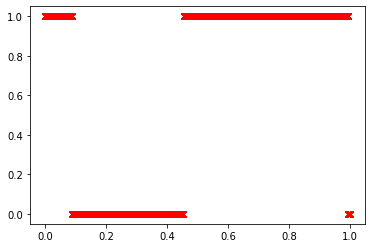

In [47]:
Y, iAnn, Lam_r = MA_Clas_Gen(X ,t, R=5, NrP=1)

In [48]:

Y = Y - 1
t = t - 1
#YMA = YMA-1


In [49]:
import numpy as np
from scipy import stats
Ytr_mv  = []
for i in range(Y.shape[0]):
     #print(Y[i])
     Ytr_mv   += [np.take(stats.mode(Y[i]),0)]
     #print(mode_Y)
#Ytr_mv 

In [50]:
Ytr_mv = np.array(Ytr_mv).reshape(-1,1) 
Ytr_mv.shape

(245057, 1)

In [51]:
from sklearn.metrics import classification_report

for i in range(Ytr_mv.shape[1]):
  print('annotator',i+1)
  print(classification_report(t,Ytr_mv))


annotator 1
              precision    recall  f1-score   support

           0       0.53      0.77      0.63     50859
           1       0.93      0.82      0.87    194198

    accuracy                           0.81    245057
   macro avg       0.73      0.79      0.75    245057
weighted avg       0.85      0.81      0.82    245057



# Split data

In [52]:
import numpy.matlib
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
Ns = 1
ss = ShuffleSplit(n_splits=Ns, test_size=0.3, random_state=123)
for train_index, test_index in ss.split(X):
    print(test_index)
    X_train, X_test,Y_train,Y_test = X[train_index,:], X[test_index,:], Ytr_mv[train_index,:], Ytr_mv[test_index,:]
    Y_true_train, Y_true_test = t[train_index].reshape(-1,1), t[test_index].reshape(-1,1)
print(X_train.shape, Y_train.shape, Y_true_train.shape)

[180274  23506 163905 ... 224310 148007  21836]
(171539, 3) (171539, 1) (171539, 1)


# Apply MinMaxScaler

In [53]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Testing the Class 


In [54]:
# from sklearn.metrics import classification_report, balanced_accuracy_score
# from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
# l1 =  0.0001
# NUM_RUNS =10
# ACC = np.zeros(NUM_RUNS)
# AUC = np.zeros(NUM_RUNS)
# MI = np.zeros(NUM_RUNS)
# NMI = np.zeros(NUM_RUNS)
# AMI = np.zeros(NUM_RUNS)
# BACC = np.zeros(NUM_RUNS)
# for i in range(NUM_RUNS): #10
#     print("iteration: " + str(i))
   
#     MA = Keras_MA_PRI(epochs=100,batch_size=256,R=5, K=2, dropout=0.2, learning_rate=0.01,optimizer='Adam', 
#                 l1_param=l1,  validation_split=0.3, verbose=0)
    
#     MA.fit(X_train, Y_train)
#    # MA.plot_history()
  
#     #Accuracy
#     pred_2 = MA.predict(X_test)
 
#     report = classification_report( pred_2.argmax(axis=1),Y_true_test.ravel(),output_dict=True)
#     ACC[i] = report['accuracy']
#     print("Validation ACC: %.4f" % (float(ACC[i])))


#     # balanced. Accurcy
#     BACC[i] = balanced_accuracy_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze(), adjusted=True)
#     print("Validation Balanced_ACC: %.4f" % (float(BACC[i])))

#     #MI
    
#     MI[i] = mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
#     print("Validation MI: %.4f" % (float(MI[i]),))
#     NMI[i] = normalized_mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
#     print("Validation Normalized MI: %.4f" % (float(NMI[i]),))
#     AMI[i]= adjusted_mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
#     print("Validation Adjusted MI: %.4f" % (float(AMI[i]),))


#     #AUC
#     val_AUC_metric = tf.keras.metrics.AUC( from_logits = True)  
#    # val_logits =MA.predict(X_test) # model(X_test, training=False)
#     # tf.print(y_batch_val)
#     val_AUC_metric.update_state(Y_true_test, pred_2.argmax(axis=1).astype('float'))

#     val_AUC = val_AUC_metric.result()
#     val_AUC_metric.reset_states()
#     val_AUC = val_AUC.numpy()
#     print("Validation aUc: %.4f" % (float(val_AUC),))
#     AUC[i] = val_AUC
    

In [55]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
import pandas as pd
l1 =  0.0001
NUM_RUNS =10
custom_loss = "MV"


results = []
for i in range(NUM_RUNS):

    print("iteration: " + str(i))
   
    MA = Keras_MA_GCCE(epochs=100,batch_size=256,R=5, K=2, dropout=0.2, learning_rate=0.01,optimizer='Adam', 
                l1_param=l1,  validation_split=0.3, verbose=0)
    
    MA.fit(X_train, Y_train)
    #MA.plot_history()
  
    # Generate the predictions for the current run
    pred_2 = MA.predict(X_test)
     
    acc, auc, auc_sk,  nmi,  bacc = evaluation_metrics(Y_true_test,  pred_2, print_result=True)  # mi, ami,
    
    # Save the results for the current run to the list of dictionaries
    results.append({
        #'run': i,
        'accuracy': acc,
        'balanced_accuracy': bacc,
       # 'mutual_information': mi,
        'normalized_mutual_information': nmi,
     #   'adjusted_mutual_information': ami,
        'auc_tensorflow': auc,
        'auc_scikit_learn': auc_sk,
    })
    
# Convert the list of dictionaries to a DataFrame
df = np.round(pd.DataFrame(results)*100, 2)

# Calculate the mean and standard deviation of each metric
mean = np.round(df.mean(),2)
std = np.round(df.std(),2)  




iteration: 0
2298/2298 [==============================] - 4s 2ms/step
Accuracy: 0.7260
Balanced Accuracy: 0.4980
Normalized Mutual Information: 0.1454
AUC (Tensorflow): 0.7490
AUC (scikit-learn): 0.8965
iteration: 1
2298/2298 [==============================] - 4s 2ms/step
Accuracy: 0.7751
Balanced Accuracy: 0.5685
Normalized Mutual Information: 0.1979
AUC (Tensorflow): 0.7843
AUC (scikit-learn): 0.8654
iteration: 2
2298/2298 [==============================] - 4s 2ms/step
Accuracy: 0.7632
Balanced Accuracy: 0.5548
Normalized Mutual Information: 0.1860
AUC (Tensorflow): 0.7774
AUC (scikit-learn): 0.8707
iteration: 3
2298/2298 [==============================] - 4s 2ms/step
Accuracy: 0.7699
Balanced Accuracy: 0.5604
Normalized Mutual Information: 0.1912
AUC (Tensorflow): 0.7802
AUC (scikit-learn): 0.8289
iteration: 4
2298/2298 [==============================] - 4s 2ms/step
Accuracy: 0.7596
Balanced Accuracy: 0.5508
Normalized Mutual Information: 0.1826
AUC (Tensorflow): 0.7754
AUC (scikit-

In [62]:
df

,accuracy,balanced_accuracy,normalized_mutual_information,auc_tensorflow,auc_scikit_learn
0,72.60,49.80,14.54,74.900002,89.65
1,77.51,56.85,19.79,78.430000,86.54
2,76.32,55.48,18.60,77.739998,87.07
3,76.99,56.04,19.12,78.019997,82.89
4,75.96,55.08,18.26,77.540001,86.34
5,82.40,64.18,26.88,82.089996,93.93
6,81.48,64.72,26.72,82.360001,92.86
7,75.34,53.97,17.45,76.989998,85.76
8,80.44,60.79,23.50,80.389999,89.22
9,78.22,56.78,19.99,78.389999,89.54


In [63]:
mean

accuracy                         77.73
balanced_accuracy                57.37
normalized_mutual_information    20.49
auc_tensorflow                   78.69
auc_scikit_learn                 88.38
dtype: float64

In [64]:
std

accuracy                         3.00
balanced_accuracy                4.62
normalized_mutual_information    4.01
auc_tensorflow                   2.31
auc_scikit_learn                 3.35
dtype: float64

In [65]:
result_df = pd.concat([mean.rename('Mean'), std.rename('Std')], axis=1)

In [66]:
result_df

,Mean,Std
accuracy,77.73,3.00
balanced_accuracy,57.37,4.62
normalized_mutual_information,20.49,4.01
auc_tensorflow,78.69,2.31
auc_scikit_learn,88.38,3.35


In [67]:
# Save the DataFrame to an excel file
result_df.to_excel(database + custom_loss + ".xlsx")